In [1]:
# Cell 1: imports + password analyzer
import string
import math
import hashlib
import bcrypt
import pyotp
import qrcode
from PIL import Image
from io import BytesIO
import base64
import time

def analyze_password_strength(password):
    """
    Returns a tuple: (score:int, rating:str, entropy:float)
    Rating: "Weak", "Moderate", "Strong"
    """
    score = 0
    feedback = []
    common_passwords = ["password", "123456", "qwerty", "letmein", "admin", "welcome", "abc123"]
    
    # Length checks
    if len(password) >= 8:
        score += 1
    if len(password) >= 12:
        score += 1
    
    # Character variety
    has_upper = any(c.isupper() for c in password)
    has_lower = any(c.islower() for c in password)
    has_digit = any(c.isdigit() for c in password)
    has_symbol = any(c in string.punctuation for c in password)
    score += sum([has_upper, has_lower, has_digit, has_symbol])
    
    # Common password penalty
    if password.lower() in common_passwords:
        score = max(0, score - 2)
        feedback.append("This password is too common.")
    
    # Entropy estimate
    pool_size = 0
    if has_lower: pool_size += 26
    if has_upper: pool_size += 26
    if has_digit: pool_size += 10
    if has_symbol: pool_size += len(string.punctuation)
    entropy = len(password) * math.log2(pool_size) if pool_size > 0 else 0.0
    
    # Rating
    if score <= 2:
        rating = "Weak"
    elif score <= 4:
        rating = "Moderate"
    else:
        rating = "Strong"
    
    return score, rating, entropy, feedback


In [2]:
# Cell 2: users "database" and core register/authenticate functions

users = {}

def generate_totp_secret():
    """Create a new base32 TOTP secret for a user."""
    return pyotp.random_base32()  # 16-char-ish base32 secret

def generate_totp_qr(provisioning_uri):
    """
    Return a PIL Image of the QR code for the provisioning URI
    (useful for scanning with Google Authenticator / Authy).
    """
    qr = qrcode.QRCode(box_size=6, border=2)
    qr.add_data(provisioning_uri)
    qr.make(fit=True)
    img = qr.make_image(fill_color="black", back_color="white")
    return img

def register_user(username, password, require_totp=True, min_rating="Moderate"):
    """
    Register a new user.
    - Analyzes password strength and rejects Weak passwords.
    - Hashes password with bcrypt (salt auto-generated).
    - Generates a TOTP secret and stores everything in users dict.
    
    min_rating: "Weak", "Moderate", or "Strong" => minimum acceptable rating
    """
    username = username.strip().lower()
    if username in users:
        print(f"❌ Username '{username}' already exists.")
        return False
    
    score, rating, entropy, feedback = analyze_password_strength(password)
    if rating == "Weak" or (min_rating == "Strong" and rating != "Strong"):
        print("❌ Password rejected due to weakness.")
        print(f"   Rating: {rating} | Entropy: {entropy:.2f} bits | Feedback: {feedback}")
        return False
    
    # Hash with bcrypt
    password_bytes = password.encode('utf-8')
    bcrypt_hash = bcrypt.hashpw(password_bytes, bcrypt.gensalt())  # bytes
    
    # Generate TOTP secret
    totp_secret = generate_totp_secret() if require_totp else None
    
    # Store in "database"
    users[username] = {
        "bcrypt_hash": bcrypt_hash,
        "totp_secret": totp_secret,
        "created_at": time.time()
    }
    
    print(f"✅ User '{username}' registered. Rating: {rating} | Entropy: {entropy:.2f} bits")
    if require_totp:
        totp = pyotp.TOTP(totp_secret)
        provisioning_uri = totp.provisioning_uri(name=username, issuer_name="DemoApp")
        print("TOTP secret (BASE32):", totp_secret)
        print("Provisioning URI:", provisioning_uri)
        # Return QR image so notebook can display it if desired
        qr_img = generate_totp_qr(provisioning_uri)
        return True, qr_img
    return True, None

def authenticate(username, password, totp_code=None, require_totp=True):
    """
    Authenticate a user:
    - Find user in "database"
    - Verify bcrypt password
    - If require_totp is True, verify provided totp_code as well
    """
    username = username.strip().lower()
    entry = users.get(username)
    if not entry:
        print("❌ User not found.")
        return False
    
    bcrypt_hash = entry["bcrypt_hash"]
    if not bcrypt.checkpw(password.encode('utf-8'), bcrypt_hash):
        print("❌ Incorrect password.")
        return False
    
    if require_totp:
        totp_secret = entry.get("totp_secret")
        if not totp_secret:
            print("⚠️ User does not have TOTP configured.")
            return False
        if totp_code is None:
            print("❌ TOTP code required but not provided.")
            return False
        totp = pyotp.TOTP(totp_secret)
        if not totp.verify(str(totp_code), valid_window=1):
            print("❌ Invalid TOTP code.")
            return False
    
    print(f"✅ Authentication success for user '{username}'.")
    return True


Register attempt 1 (weak):
✅ User 'alice' registered. Rating: Moderate | Entropy: 41.68 bits
TOTP secret (BASE32): TBN32M7OXKMMXO5CIWN3NFETL4QS5S3U
Provisioning URI: otpauth://totp/DemoApp:alice?secret=TBN32M7OXKMMXO5CIWN3NFETL4QS5S3U&issuer=DemoApp

Register attempt 2 (strong):
✅ User 'bob' registered. Rating: Strong | Entropy: 65.55 bits
TOTP secret (BASE32): QSX5XFNNMWBIFTL4HX4ZRQ6MQPLRSJTN
Provisioning URI: otpauth://totp/DemoApp:bob?secret=QSX5XFNNMWBIFTL4HX4ZRQ6MQPLRSJTN&issuer=DemoApp



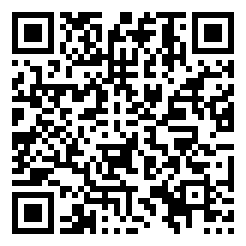

Scan this QR with Google Authenticator / Authy or use the BASE32 secret shown above.

Authenticate attempt (bob) - missing TOTP:
❌ TOTP code required but not provided.

Generated current TOTP code (for demo): 536429
Authenticate attempt (bob) - with correct TOTP:
✅ Authentication success for user 'bob'.

Authenticate with wrong password:
❌ Incorrect password.

Authenticate with wrong TOTP:
❌ Invalid TOTP code.



In [3]:
# Cell 3: Demo registrations and authentication flows

# 1) Try registering with a weak password (should be rejected)
print("Register attempt 1 (weak):")
res = register_user("alice", "Pass123")  # "Pass123" is short (7) -> likely Moderate/Weak
print()

# 2) Register with a stronger password
print("Register attempt 2 (strong):")
success, qr_img = register_user("bob", "MyP@ssw0rd", require_totp=True, min_rating="Moderate")
print()

# If registration returned a QR image, display it (useful in Jupyter)
if success and qr_img is not None:
    display(qr_img)  # in Jupyter this shows the QR code inline
    print("Scan this QR with Google Authenticator / Authy or use the BASE32 secret shown above.\n")

# 3) Authenticate with correct password but missing TOTP
print("Authenticate attempt (bob) - missing TOTP:")
authenticate("bob", "MyP@ssw0rd", totp_code=None, require_totp=True)
print()

# 4) Generate current TOTP code and authenticate successfully
bob_secret = users["bob"]["totp_secret"]
totp_for_bob = pyotp.TOTP(bob_secret)
current_code = totp_for_bob.now()
print("Generated current TOTP code (for demo):", current_code)
print("Authenticate attempt (bob) - with correct TOTP:")
authenticate("bob", "MyP@ssw0rd", totp_code=current_code, require_totp=True)
print()

# 5) Wrong password / wrong TOTP examples
print("Authenticate with wrong password:")
authenticate("bob", "WrongPassword", totp_code=current_code, require_totp=True)
print()

print("Authenticate with wrong TOTP:")
authenticate("bob", "MyP@ssw0rd", totp_code="000000", require_totp=True)
print()
